# JAX & Flax

Example from: https://flax.readthedocs.io/en/latest/getting_started.html

In [ ]:
pip install flax

In [ ]:
pip install tensorflow-datasets

In [18]:
# IMPORTANT: suppress annoying Tensorflow warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [19]:
# Loading data
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

def get_datasets(num_epochs, batch_size):
  """Load MNIST train and test datasets into memory."""
  train_ds = tfds.load('mnist', split='train')
  test_ds = tfds.load('mnist', split='test')

  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                           tf.float32) / 255.,
                                          'label': sample['label']}) # normalize train set
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                         tf.float32) / 255.,
                                        'label': sample['label']}) # normalize test set

  train_ds = train_ds.repeat(num_epochs).shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

In [7]:
# Define network
from flax import linen as nn  # Linen API

class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

In [9]:
# View model layers
import jax
import jax.numpy as jnp  # JAX NumPy

cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1))))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,… │ float32[1,10]     │                   │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,… │ float32[1,28,28,… │ bias: float32[32] │
│         │        │                   │                   │ kernel:           │
│         │        │                   │                   │ float32[3,3,1,32] │
│         │        │                   │                   │                   │
│         │        │                   │                   │ 320 (1.3 KB)      │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_1  │ Conv   │ float3

In [ ]:
pip install clu

In [11]:
# Create a TrainState
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')
    
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

In [12]:
# Training step
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [13]:
# Metric computation
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [16]:
# Download data
num_epochs = 10
batch_size = 32

train_ds, test_ds = get_datasets(num_epochs, batch_size)

In [20]:
# Seed randomness
tf.random.set_seed(0)
init_rng = jax.random.key(0)

In [21]:
# Initialize the TrainState
learning_rate = 0.01
momentum = 0.9

state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [22]:
# Train and evaluate

# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

for step,batch in enumerate(train_ds.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.20215867459774017, accuracy: 93.79499816894531
test epoch: 1, loss: 0.07719115912914276, accuracy: 97.4959945678711
train epoch: 2, loss: 0.0593988299369812, accuracy: 98.17333221435547
test epoch: 2, loss: 0.05029089003801346, accuracy: 98.41746520996094
train epoch: 3, loss: 0.03973779454827309, accuracy: 98.82333374023438
test epoch: 3, loss: 0.04721147194504738, accuracy: 98.50761413574219
train epoch: 4, loss: 0.028541523963212967, accuracy: 99.15166473388672
test epoch: 4, loss: 0.03852767124772072, accuracy: 98.84815979003906
train epoch: 5, loss: 0.02252519130706787, accuracy: 99.34000396728516
test epoch: 5, loss: 0.033215705305337906, accuracy: 98.88822174072266
train epoch: 6, loss: 0.017439551651477814, accuracy: 99.51000213623047
test epoch: 6, loss: 0.037596695125103, accuracy: 98.828125
train epoch: 7, loss: 0.013739250600337982, accuracy: 99.66500091552734
test epoch: 7, loss: 0.03493726998567581, accuracy: 98.91827392578125
train epoch: 8, loss:

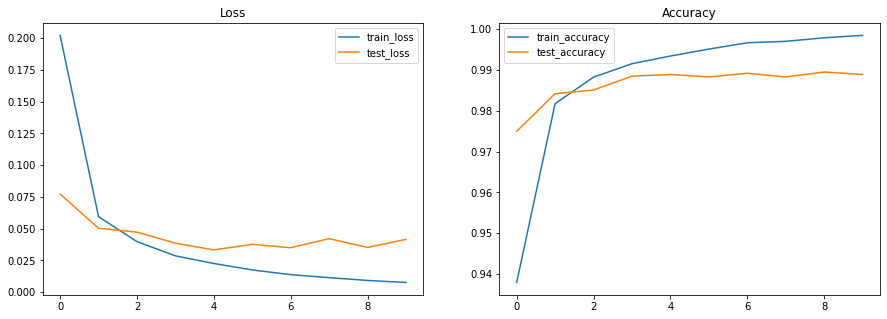

<Figure size 432x288 with 0 Axes>

In [23]:
# Visualize metrics
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

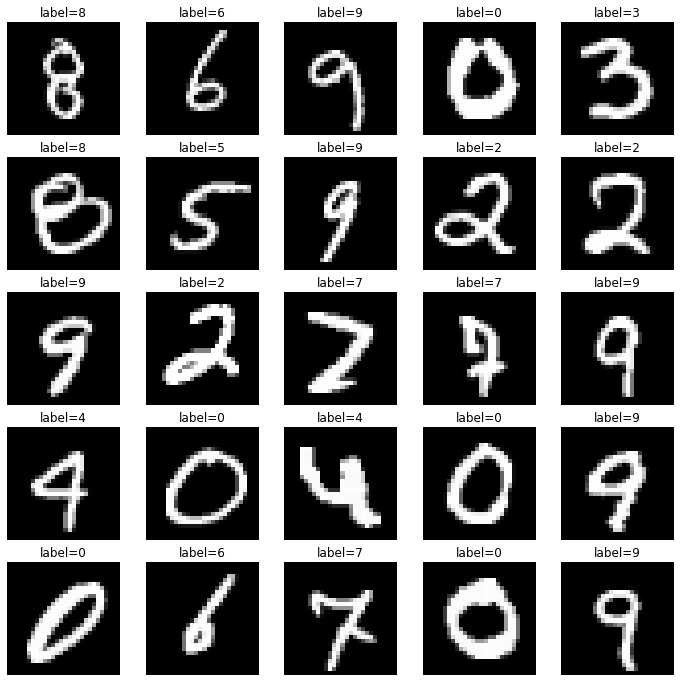

In [24]:
# Perform inference on test set
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')